In [1]:
import numpy as np
from  scipy.misc import imresize
from scipy.misc import imsave
from scipy.ndimage import imread
import matplotlib.pyplot as plt
from numpy.linalg import inv

In [2]:
def getGrid_r(M, N):
    #create the reference space [M, N, 3]
    grid_r = np.asarray(np.meshgrid(np.arange(M), np.arange(N), indexing = 'ij'))
    grid_r = np.rollaxis(grid_r, 0, 3)
    grid_r = np.concatenate((grid_r[:,:,0].reshape([M,N,1]), grid_r[:,:,1].reshape([M,N,1]), np.ones([M, N, 1])), axis = 2)
    grid_r[:, :, 0] = grid_r[:, :, 0] - M//2
    grid_r[:, :, 1] = grid_r[:, :, 1] - N//2
    return grid_r

In [3]:
def getTrans(trans_matrix, grid_r):
    #create the rigid transformation
    rg_trans = grid_r.dot(trans_matrix.T)
    rg_trans = np.split(rg_trans, [2], axis=2)[0]
    return rg_trans

In [4]:
def getCoordinate(rg_trans):
    #split the rg_transformation
    y1_rg, y2_rg = np.split(rg_trans,[1], axis=2)
    # y1_rg,y2 _rg shape = (M, N)
    y1_rg = y1_rg.squeeze()
    y2_rg = y2_rg.squeeze()
    # crate the floor, ceil coordinate
    y1_floor = np.floor(y1_rg).astype(int)
    y1_ceil = np.floor(y1_rg+1).astype(int)
    y2_floor = np.floor(y2_rg).astype(int)
    y2_ceil = np.floor(y2_rg+1).astype(int)

    floor_ceil = [y1_floor, y1_ceil, y2_floor, y2_ceil]
    y1_y2_rg = [y1_rg, y2_rg]
    #temp_00_coor -> (y1_floor, y2_floor)
    #temp_10_coor -> (y1_ceil, y2_floor)
    #temp_01_coor -> (y1_floor, y2_ceil)
    #temp_11_coor -> (y1_ceil, y2_ceil)
    return floor_ceil, y1_y2_rg

In [5]:
def map_template(y1_coor, y2_coor, template, M, N):
    #flat坐标空间，y*N+x
    flat = ((y1_coor+M//2)*N + y2_coor+N//2).reshape((M*N,))
    #将不再坐标范围内的点标记为0
    flat[flat>=M*N] = 0
    flat[flat<0] = 0
    #根据展开的坐标得到转换后的图片
    new = np.take(template, flat).reshape((M, N))
    #查找rg_trans中不再坐标范围内的点
    y1_del_mul = (y1_coor>=(-M//2))*(y1_coor<(M//2))
    y2_del_mul = (y2_coor>=(-N//2))*(y2_coor<(N//2))
    #将rg_trans中不再坐标空间内的点的值设置为0
    new = new * y1_del_mul * y2_del_mul
    return new

In [6]:
def bilinear(floor_ceil, y1_y2_rg, template, M, N):
    [y1_rg, y2_rg] = y1_y2_rg
    [y1_floor, y1_ceil, y2_floor, y2_ceil] = floor_ceil
    temp_00 = map_template(y1_floor, y2_floor, template, M, N)
    temp_10 = map_template(y1_ceil, y2_floor, template, M, N)
#     fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 10))
#     ax0.imshow(temp_00)
#     ax1.imshow(temp_10)
    
    temp_01 = map_template(y1_floor, y2_ceil, template, M, N)
    temp_11 = map_template(y1_ceil, y2_ceil, template, M, N)
    temp = [temp_00, temp_10, temp_01, temp_11]
#     xr1 = (x1_rg-x1_floor)
#     xr2 = x2_rg-x2_floor
    gen_image = (1-(y1_rg-y1_floor)) * ((1-(y2_rg-y2_floor)) * temp_00 + (y2_rg - y2_floor) * temp_01)\
                + (y1_rg - y1_floor) * ((1-(y2_rg-y2_floor)) * temp_10 + (y2_rg - y2_floor) * temp_11)
    dT = getDerivation_Y1Y2(floor_ceil, y1_y2_rg, temp)
    return gen_image, dT

In [7]:
def getDerivation_Y1Y2(floor_ceil, y1_y2_rg, temp):
    [y1_rg, y2_rg] = y1_y2_rg
    [temp_00, temp_10, temp_01, temp_11] = temp
    [y1_floor, y1_ceil, y2_floor, y2_ceil] = floor_ceil
    #     yr1 = y1_rg-y1_floor
    #     yr2 = y2_rg-y2_floor
    dTdy1 = (1 - (y2_rg-y2_floor)) * (temp_10 - temp_00) + (y2_rg-y2_floor) * (temp_11 - temp_01)
    dTdy2 = (1 - (y1_rg-y1_floor)) * (temp_01 - temp_00) + (y1_rg-y1_floor) * (temp_11 - temp_10)
    return [dTdy1, dTdy2]

In [8]:
def getCost(reference, gen_image):
    return np.sum(np.power(gen_image - reference, 2))/2

In [9]:
def computeGradient(reference, gen_image, dT, grid_r):
    [dTdy1, dTdy2]  =dT
    grid_x1, grid_x2, _ = np.split(grid_r, [1,2], axis=2)
    grid_x1 = grid_x1.squeeze()
    grid_x2 = grid_x2.squeeze()
    
    dw1 = np.sum((gen_image - reference) * dTdy1 * grid_x1)
    dw2 = np.sum((gen_image - reference) * dTdy1 * grid_x2)
    dw3 = np.sum((gen_image - reference) * dTdy1)
    
    dw4 = np.sum((gen_image - reference) * dTdy2 * grid_x1)
    dw5 = np.sum((gen_image - reference) * dTdy2 * grid_x2)
    dw6 = np.sum((gen_image - reference) * dTdy2)
    
    dw = [dw1, dw2, dw3, dw4, dw5, dw6, 0, 0, 0]
    return dw

In [10]:
def testGradient(M, N, trans_matrix, e, reference, template):
    [[w1, w2, w3], [w4, w5, w6], [w7, w8, w9]] = trans_matrix
    grid_r = getGrid_r(M, N)
    rg_trans = getTrans(trans_matrix, grid_r)
    floor_ceil, y1_y2_rg = getCoordinate(rg_trans)
    gen_image, dT = bilinear(floor_ceil=floor_ceil, y1_y2_rg=y1_y2_rg, template=template, M=M, N=N)
    cost = getCost(reference, gen_image)
    gradient = computeGradient(reference=reference, gen_image=gen_image, dT=dT, grid_r=grid_r)
    print("cost is " + str(cost))
    
    cost_6 = np.zeros((6))
    nu_gradient = np.zeros_like(cost)
    trans_matrix_copy = np.zeros_like(trans_matrix)
    
    for i in range(6):
        #深复制
        trans_matrix_copy = trans_matrix.copy()
        flat_trans_marix = trans_matrix_copy.reshape((-1,))
        flat_trans_marix[i] = flat_trans_marix[i]+e
        new_trans_matrix = flat_trans_marix.reshape(trans_matrix.shape)
#         print(new_trans_matrix)
        rg_trans = getTrans(new_trans_matrix, grid_r)
        floor_ceil, y1_y2_rg = getCoordinate(rg_trans)
        gen_image, dT = bilinear(floor_ceil=floor_ceil, y1_y2_rg=y1_y2_rg, template=template, M=M, N=N)
        cost_6[i] = getCost(reference, gen_image)
        print("cost_" + str(i) + " is " + str(cost_6[i]))
        
    
    nu_gradient = (cost_6 - cost) / e
    error_ratio = (nu_gradient - gradient[:6]) / gradient[:6]
    
    print("transformaiton matrix is ")
    print(trans_matrix)
    print("derivative gradient is ")
    print(gradient)
    print('\n')
    print("numerical gradient is ")
    print(nu_gradient)
    print('\n')
    print("error ratio is ")
    print(error_ratio)
    return gen_image, nu_gradient, cost

In [11]:
def getTrans_matrix(angle):
    matrix = np.array([[np.cos(angle), np.sin(angle), 0], [-np.sin(angle), np.cos(angle), 0],[0,0,1]])
    return inv(matrix)

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  if __name__ == '__main__':


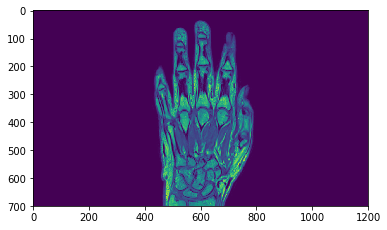

In [12]:
image = imread('MRI_hand.jpg', flatten=True)
plt.imshow(image)

In [13]:
def cropImage(image):
    assert(len(image.shape)==2), "Image should bu grey image"
    height, width =image.shape
    crop_size = max(height, width)
    new_image = np.zeros((crop_size, crop_size))
    new_image[(crop_size-height)//2:(height+crop_size)//2, (crop_size-width)//2:(width+crop_size)//2] = image
    return new_image

In [14]:
def downSample(image, size):
    new_image = cropImage(image)
    return imresize(new_image, size)

In [15]:
def getAffine(M, N, trans_matrix, template):
    grid_r = getGrid_r(M, N)
    rg_trans = getTrans(trans_matrix, grid_r)
    floor_ceil, y1_y2_rg = getCoordinate(rg_trans)
    gen_image, _ = bilinear(floor_ceil, y1_y2_rg, template, M, N)
    return gen_image

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  app.launch_new_instance()


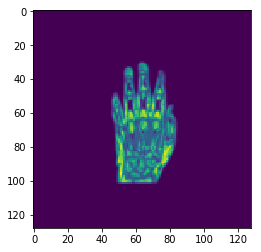

In [16]:
# 得到downsample字典
downsample_img = {}
downsample_img[4] = downSample(image,[4,4])
# imsave("4x4_hand.jpg",downsample_img[4])
downsample_img[8] = downSample(image,[8,8])
# imsave("8x8_hand.jpg",downsample_img[8])
downsample_img[16] = downSample(image,[16,16])
# imsave("16x16_hand.jpg",downsample_img[16])
downsample_img[32] = downSample(image,[32,32])
# imsave("32x32_hand.jpg",downsample_img[32])
downsample_img[64] = downSample(image,[64,64])
# imsave("64x64_hand.jpg",downsample_img[64])
downsample_img[128] = downSample(image,[128,128])
# imsave("128x128_hand.jpg",downsample_img[128])
plt.imshow(downsample_img[128])

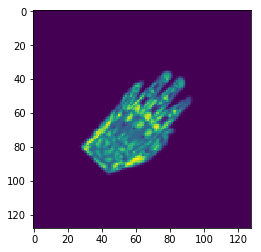

In [17]:
# 沿图像中心顺时针旋转30度
trans_matrix = getTrans_matrix(np.pi/4)

# 得到template
gen_DS_img = {}
gen_DS_img[4] = getAffine(4, 4, trans_matrix, downsample_img[4])
# imsave("4x4_30_hand.jpg", gen_DS_img[4])
gen_DS_img[8] = getAffine(8, 8, trans_matrix, downsample_img[8])
# imsave("8x8_30_hand.jpg", gen_DS_img[8])
gen_DS_img[16] = getAffine(16, 16, trans_matrix, downsample_img[16])
# imsave("16x16_30_hand.jpg", gen_DS_img[16])
gen_DS_img[32] = getAffine(32, 32, trans_matrix, downsample_img[32])
# imsave("32x32_30_hand.jpg", gen_DS_img[32])
gen_DS_img[64] = getAffine(64, 64, trans_matrix, downsample_img[64])
# imsave("64x64_30_hand.jpg", gen_DS_img[64])
gen_DS_img[128] = getAffine(128, 128, trans_matrix, downsample_img[128])
# imsave("128x128_30_hand.jpg", gen_DS_img[128])
plt.imshow(gen_DS_img[128])

Text(0.5,1,'template')

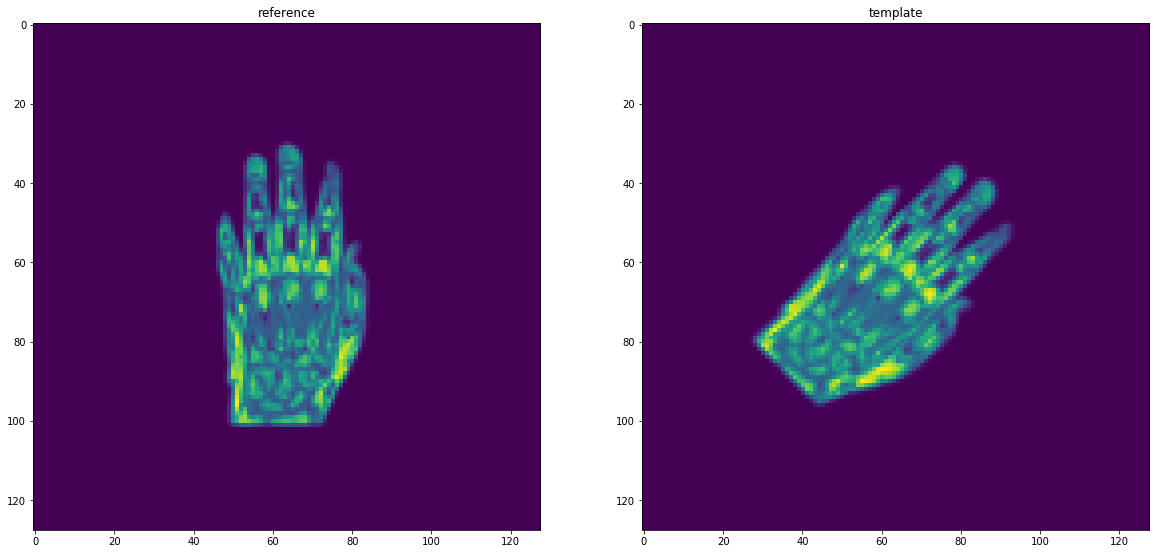

In [18]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 10))
ax0.imshow(downsample_img[128])
ax0.set_title("reference")
ax1.imshow(gen_DS_img[128])
ax1.set_title("template")

cost is 6346371.412527866


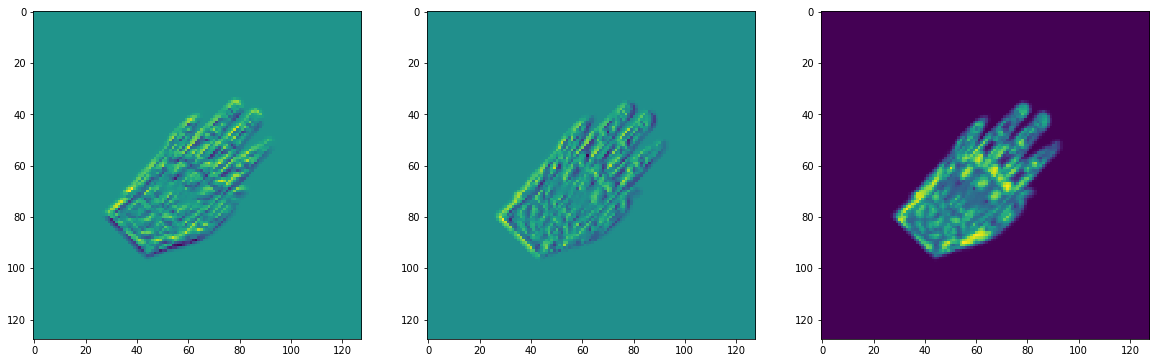

In [19]:
trans_matrix = getTrans_matrix(0)
M, N = 128, 128
template = gen_DS_img[128]
reference = downsample_img[128]
grid_r = getGrid_r(M, N)
rg_trans = getTrans(trans_matrix, grid_r)
floor_ceil, y1_y2_rg = getCoordinate(rg_trans)
gen_image, dT = bilinear(floor_ceil=floor_ceil, y1_y2_rg=y1_y2_rg, template=template, M=M, N=N)
cost = getCost(reference, gen_image)
gradient = computeGradient(reference=reference, gen_image=gen_image, dT=dT, grid_r=grid_r)
print("cost is " + str(cost))
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 10))
ax0.imshow(dT[0])
ax1.imshow(dT[1])
ax2.imshow(gen_image)



0th iteration loss: is 3855.5793785032856
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
cost is 3855.5793785032856
cost_0 is 3855.6678043431116
cost_1 is 3855.3803179272763
cost_2 is 3855.5771743150103
cost_3 is 3856.0551744212817
cost_4 is 3855.216350356234
cost_5 is 3855.454028205202
transformaiton matrix is 
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
derivative gradient is 
[4055.200150327681, 1133.075785580336, -22.757558476489294, 7153.6786672838825, -5537.345113154066, -1254.2024655716302, 0, 0, 0]


numerical gradient is 
[  884.25839826 -1990.60576009   -22.04188275  4757.95917996
 -3630.28147051 -1253.50298084]


error ratio is 
[-7.81944574e-01 -2.75681608e+00 -3.14478253e-02 -3.34893360e-01
 -3.44400359e-01 -5.57712774e-04]


100th iteration loss: is 2715.440191294202
[[ 0.92387426  0.01562554 -0.03631375]
 [-0.07641196  1.04991996  0.04262563]
 [ 0.          0.          1.        ]]
cost is 2715.440191294202
cost_0 is 2715.789118681708
cost_1 is 2715.34319494614
cost_2 is 2715.667088937



1000th iteration loss: is 1075.2645134221057
[[ 0.80102321  0.09988987 -0.2072667 ]
 [-0.30712877  1.21243596  0.24275924]
 [ 0.          0.          1.        ]]
cost is 1075.2645134221057
cost_0 is 1075.2862909365588
cost_1 is 1075.2347673211625
cost_2 is 1075.3084881229684
cost_3 is 1075.304366960977
cost_4 is 1075.2365256348835
cost_5 is 1075.1947214836086
transformaiton matrix is 
[[ 0.80102321  0.09988987 -0.2072667 ]
 [-0.30712877  1.21243596  0.24275924]
 [ 0.          0.          1.        ]]
derivative gradient is 
[215.8559803574496, -297.95536938282186, 439.09551862032225, 397.73761344991567, -280.7571946281092, -698.5032230120127, 0, 0, 0]


numerical gradient is 
[ 217.77514453 -297.46100943  439.74700863  398.53538871 -279.87787222
 -697.91938497]


error ratio is 
[ 0.00889095 -0.00165917  0.00148371  0.00200578 -0.00313197 -0.00083584]


1100th iteration loss: is 1060.9644509053069
[[ 0.79825998  0.10431114 -0.21375272]
 [-0.31274846  1.21647055  0.2530569 ]
 [ 0.   



2000th iteration loss: is 6812.171998265441
[[ 0.79091097  0.12750618 -0.24520467]
 [-0.3432511   1.23049838  0.30872875]
 [ 0.          0.          1.        ]]
cost is 6812.171998265441
cost_0 is 6812.829766625549
cost_1 is 6811.696859233338
cost_2 is 6812.778826259531
cost_3 is 6813.708438772777
cost_4 is 6811.45327453676
cost_5 is 6813.074126581212
transformaiton matrix is 
[[ 0.79091097  0.12750618 -0.24520467]
 [-0.3432511   1.23049838  0.30872875]
 [ 0.          0.          1.        ]]
derivative gradient is 
[6559.37669158317, -4683.463766022627, 6066.583504835611, 15356.592308267269, -7194.368342268831, 9019.773941650088, 0, 0, 0]


numerical gradient is 
[ 6577.68360108 -4751.39032103  6068.2799409  15364.40507336
 -7187.23728682  9021.28315771]


error ratio is 
[ 0.00279095  0.01450349  0.00027964  0.00050876 -0.0009912   0.00016732]


2100th iteration loss: is 5833.371991183557
[[ 0.77793446  0.14259852 -0.26399806]
 [-0.3857172   1.24535035  0.27922273]
 [ 0.          

/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)




2500th iteration loss: is 4834.956576593064
[[ 0.78065576  0.18186622 -0.2947581 ]
 [-0.46120765  1.21586632  0.20551567]
 [ 0.          0.          1.        ]]
cost is 4834.956576593064
cost_0 is 4834.960532940238
cost_1 is 4834.7476984815385
cost_2 is 4835.0375388524
cost_3 is 4835.274927004362
cost_4 is 4835.221131385484
cost_5 is 4835.279302601851
transformaiton matrix is 
[[ 0.78065576  0.18186622 -0.2947581 ]
 [-0.46120765  1.21586632  0.20551567]
 [ 0.          0.          1.        ]]
derivative gradient is 
[22.768024247681296, -2092.643229959496, 808.0592838957086, 3176.31111420024, 2638.9769775549985, 3225.835426410316, 0, 0, 0]


numerical gradient is 
[   39.56347175 -2088.78111525   809.62259336  3183.50411299
  2645.5479242   3227.26008787]


error ratio is 
[ 7.37676986e-01 -1.84556768e-03  1.93464699e-03  2.26457627e-03
  2.48995982e-03  4.41641085e-04]


2600th iteration loss: is 4724.500097904
[[ 0.78129864  0.19063703 -0.29733521]
 [-0.4713439   1.20552348  0.193



3500th iteration loss: is 4147.609900748366
[[ 0.7841326   0.276988   -0.28835065]
 [-0.51216554  1.12374757  0.13296206]
 [ 0.          0.          1.        ]]
cost is 4147.609900748366
cost_0 is 4147.621048861204
cost_1 is 4147.347898415434
cost_2 is 4147.52195705683
cost_3 is 4147.7094590075985
cost_4 is 4147.80482035131
cost_5 is 4147.705113768487
transformaiton matrix is 
[[ 0.7841326   0.276988   -0.28835065]
 [-0.51216554  1.12374757  0.13296206]
 [ 0.          0.          1.        ]]
derivative gradient is 
[94.65177369494904, -2624.169309751528, -881.0621303953203, 986.945770202814, 1942.602205014642, 950.5489020125241, 0, 0, 0]


numerical gradient is 
[  111.48112838 -2620.02332932  -879.43691537   995.58259232
  1949.19602944   952.1302012 ]


error ratio is 
[ 0.17780285 -0.00157992 -0.00184461  0.00875106  0.00339433  0.00166356]


3600th iteration loss: is 4096.472156476163
[[ 0.78367314  0.28712122 -0.28482734]
 [-0.51609204  1.11619707  0.12949868]
 [ 0.          0



4500th iteration loss: is 17778.223698337075
[[ 0.74409955  0.51869261 -0.25615315]
 [-0.66312704  0.91408473  0.12684854]
 [ 0.          0.          1.        ]]
cost is 17778.223698337075
cost_0 is 17778.963812767724
cost_1 is 17774.802470198894
cost_2 is 17777.18088413107
cost_3 is 17779.77310869759
cost_4 is 17782.198152138095
cost_5 is 17777.992976869722
transformaiton matrix is 
[[ 0.74409955  0.51869261 -0.25615315]
 [-0.66312704  0.91408473  0.12684854]
 [ 0.          0.          1.        ]]
derivative gradient is 
[7258.91984572979, -34253.682348067516, -10432.120926415646, 15411.778117839449, 39703.341942769366, -2310.4075629652384, 0, 0, 0]


numerical gradient is 
[  7401.1443065  -34212.28138181 -10428.14206005  15494.10360516
  39744.5380102   -2307.21467353]


error ratio is 
[ 0.01959306 -0.00120866 -0.00038141  0.00534173  0.0010376  -0.00138196]


4600th iteration loss: is 15117.0853719396
[[ 0.73917128  0.55164364 -0.24575693]
 [-0.67342089  0.87855951  0.12842956



5500th iteration loss: is 8650.095057195296
[[ 0.7231464   0.68498038 -0.15575524]
 [-0.70537287  0.73558784  0.11588942]
 [ 0.          0.          1.        ]]
cost is 8650.095057195296
cost_0 is 8650.20706576325
cost_1 is 8649.533708491674
cost_2 is 8649.218597946208
cost_3 is 8650.205346024644
cost_4 is 8650.779312340377
cost_5 is 8650.398795257306
transformaiton matrix is 
[[ 0.7231464   0.68498038 -0.15575524]
 [-0.70537287  0.73558784  0.11588942]
 [ 0.          0.          1.        ]]
derivative gradient is 
[1002.895875652117, -5665.805865394435, -8769.044203549629, 1005.832692582168, 6796.540137282645, 3033.910637873487, 0, 0, 0]


numerical gradient is 
[ 1120.08567954 -5613.48703623 -8764.59249088  1102.88829348
  6842.55145081  3037.3806201 ]


error ratio is 
[ 0.11685142 -0.00923414 -0.00050766  0.09649279  0.00676981  0.00114373]


5600th iteration loss: is 8498.29332138278
[[ 0.72185908  0.69021599 -0.14738577]
 [-0.70633882  0.72935554  0.11284416]
 [ 0.          0



6500th iteration loss: is 33278.02967010425
[[ 0.70919945  0.71197213 -0.09357016]
 [-0.70857832  0.70752382  0.07868936]
 [ 0.          0.          1.        ]]
cost is 33278.02967010425
cost_0 is 33278.29599329359
cost_1 is 33277.98635636759
cost_2 is 33276.208900359044
cost_3 is 33278.206560391205
cost_4 is 33278.21791626104
cost_5 is 33279.57105922041
transformaiton matrix is 
[[ 0.70919945  0.71197213 -0.09357016]
 [-0.70857832  0.70752382  0.07868936]
 [ 0.          0.          1.        ]]
derivative gradient is 
[754.8707854407694, -977.6167600189019, -18223.480646575932, 76.66636403438315, 1276.9468683455325, 15399.132949541865, 0, 0, 0]


numerical gradient is 
[  2663.23189338   -433.13736664 -18207.69745209   1768.90286952
   1882.46156787  15413.89116159]


error ratio is 
[ 2.52806327e+00 -5.56945641e-01 -8.66091105e-04  2.20727372e+01
  4.74189424e-01  9.58379416e-04]


6600th iteration loss: is 33141.869839835024
[[ 0.70901518  0.71215046 -0.08917891]
 [-0.70851121  0



7500th iteration loss: is 32280.250306139802
[[ 0.70801287  0.71156964 -0.05758782]
 [-0.70777404  0.70777085  0.04557241]
 [ 0.          0.          1.        ]]
cost is 32280.250306139802
cost_0 is 32281.30978027031
cost_1 is 32280.856565967308
cost_2 is 32279.233120985646
cost_3 is 32281.36602259035
cost_4 is 32280.86792305275
cost_5 is 32281.387103096622
transformaiton matrix is 
[[ 0.70801287  0.71156964 -0.05758782]
 [-0.70777404  0.70777085  0.04557241]
 [ 0.          0.          1.        ]]
derivative gradient is 
[-2740.772569459572, -71.1277124787257, -10884.468974634237, 6464.262935773077, -2274.5432258612755, 9461.340772672622, 0, 0, 0]


numerical gradient is 
[ 10594.74130507   6062.59827506 -10171.85154156  11157.16450549
   6176.16912947  11367.9695682 ]


error ratio is 
[-4.86560396e+00 -8.62353895e+01 -6.54710335e-02  7.25976282e-01
 -3.71534480e+00  2.01517823e-01]


7600th iteration loss: is 32233.230706391834
[[ 0.70792245  0.71136452 -0.055112  ]
 [-0.70798015



8500th iteration loss: is 119102.44860764255
[[ 0.70807727  0.70845472 -0.03615839]
 [-0.7077595   0.70698078  0.02963731]
 [ 0.          0.          1.        ]]
cost is 119102.44860764255
cost_0 is 119110.3266552116
cost_1 is 119103.85792121603
cost_2 is 119099.58386914607
cost_3 is 119105.27733617648
cost_4 is 119103.05389162428
cost_5 is 119104.22701031409
transformaiton matrix is 
[[ 0.70807727  0.70845472 -0.03615839]
 [-0.7077595   0.70698078  0.02963731]
 [ 0.          0.          1.        ]]
derivative gradient is 
[930.4912681829301, -72.33898013124053, -28780.93406251649, -611.2050748992187, -253.27622596036963, 17727.573557728407, 0, 0, 0]


numerical gradient is 
[ 78780.47569044  14093.13573473 -28647.38496486  28287.28533932
   6052.83981728  17784.02671538]


error ratio is 
[ 8.36654648e+01 -1.95820769e+02 -4.64019331e-03 -4.72811690e+01
 -2.48981760e+01  3.18448306e-03]


8600th iteration loss: is 119034.64421374595
[[ 0.70802984  0.70843151 -0.03443666]
 [-0.70772



9500th iteration loss: is 118580.74741807769
[[ 0.707662    0.70834341 -0.02154855]
 [-0.70754062  0.70700637  0.01956438]
 [ 0.          0.          1.        ]]
cost is 118580.74741807769
cost_0 is 118590.92677877058
cost_1 is 118582.09017313075
cost_2 is 118578.80708417404
cost_3 is 118583.62904165019
cost_4 is 118581.7595794875
cost_5 is 118582.18986838573
transformaiton matrix is 
[[ 0.707662    0.70834341 -0.02154855]
 [-0.70754062  0.70700637  0.01956438]
 [ 0.          0.          1.        ]]
derivative gradient is 
[5322.602179563808, 2977.320001495671, -19461.005418464316, -63.89986054651672, 482.04956422935356, 14164.074537256496, 0, 0, 0]


numerical gradient is 
[101793.60692884  13427.55053061 -19403.33903651  28816.23572495
  10121.61409803  14424.50308037]


error ratio is 
[ 1.81247821e+01  3.50994536e+00 -2.96317589e-03 -4.51959290e+02
  1.99970402e+01  1.83865555e-02]


9600th iteration loss: is 118546.56114200648
[[ 0.70762426  0.70834797 -0.02037887]
 [-0.707531

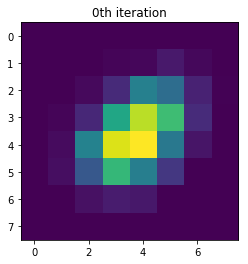

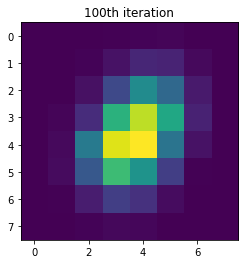

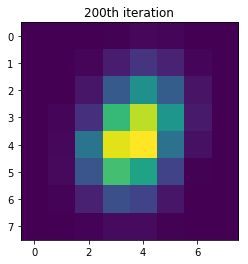

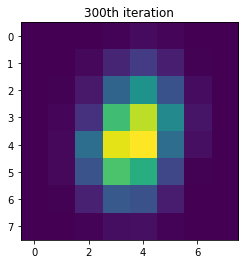

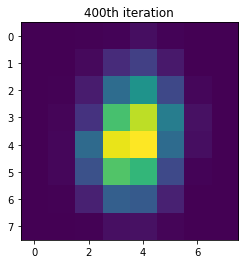

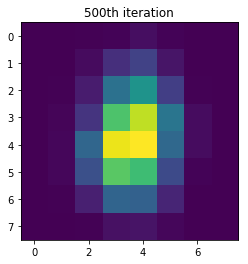

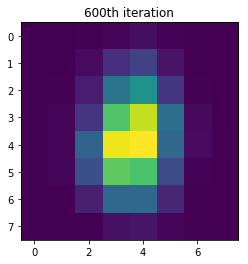

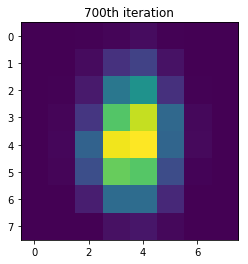

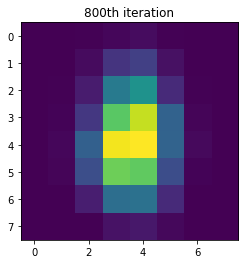

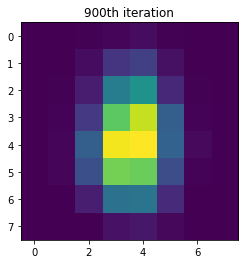

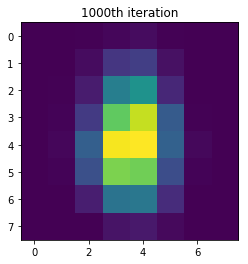

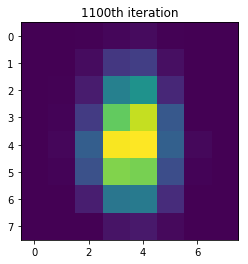

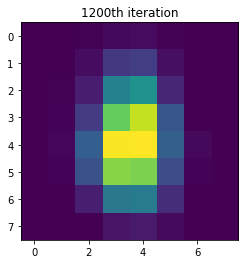

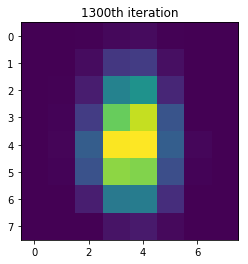

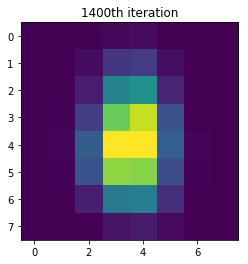

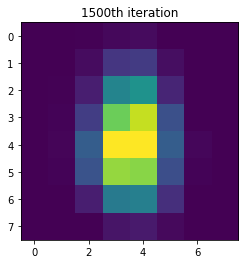

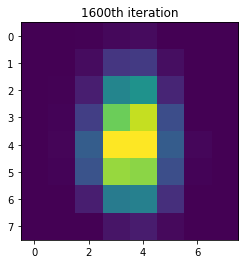

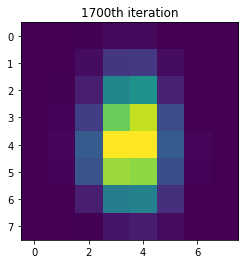

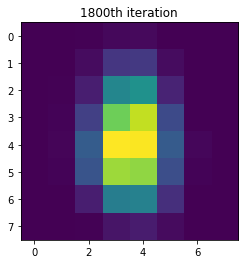

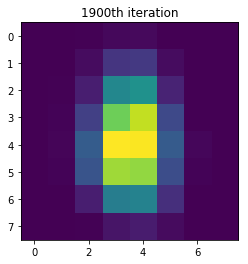

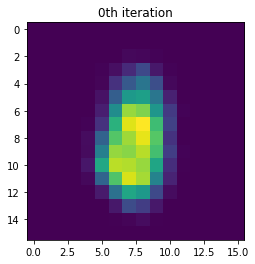

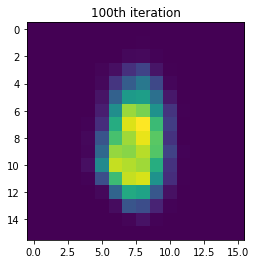

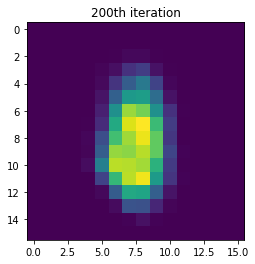

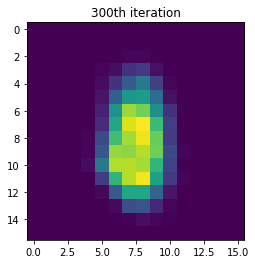

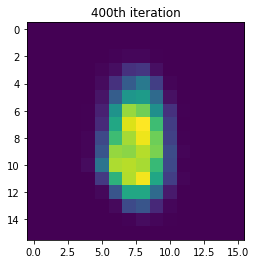

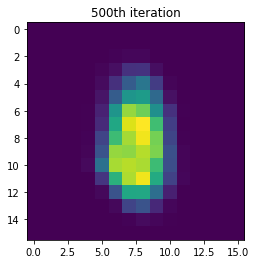

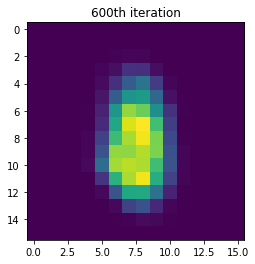

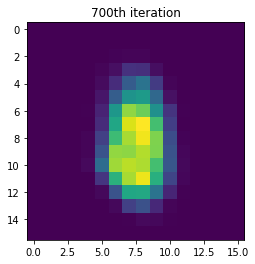

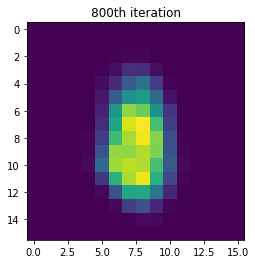

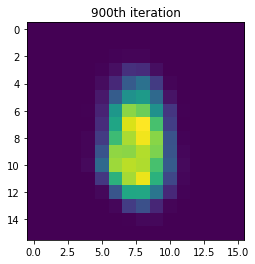

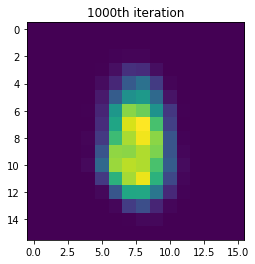

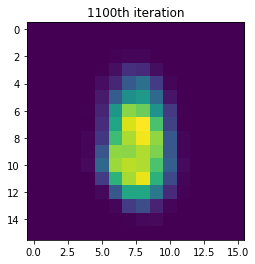

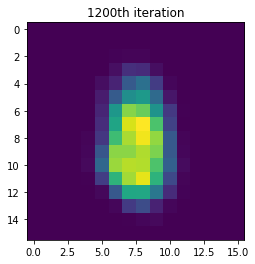

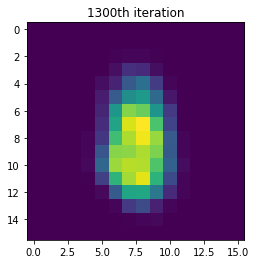

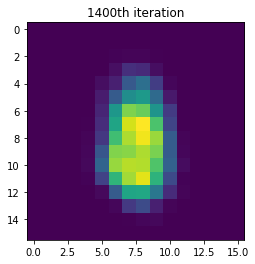

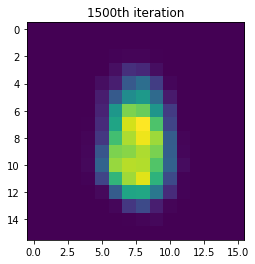

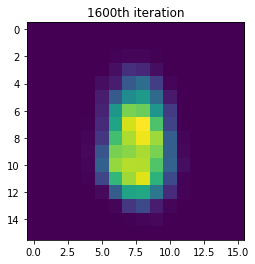

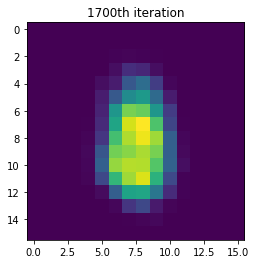

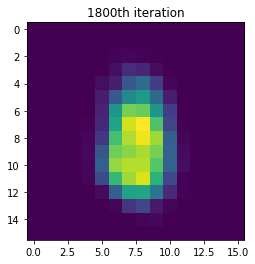

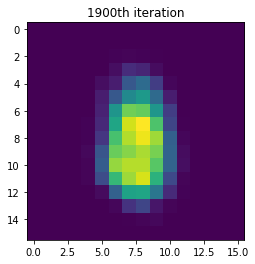

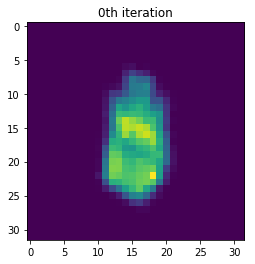

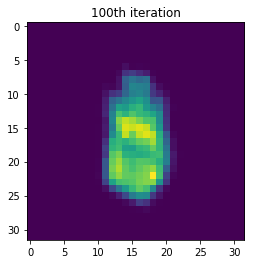

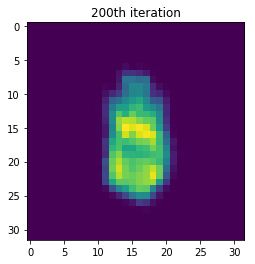

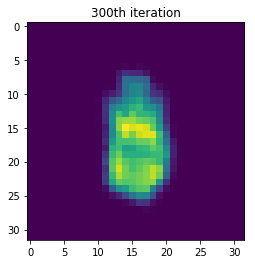

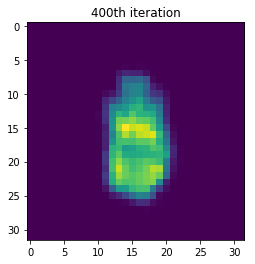

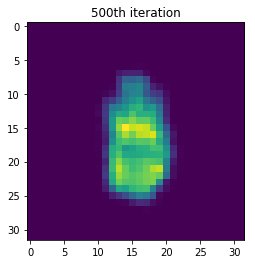

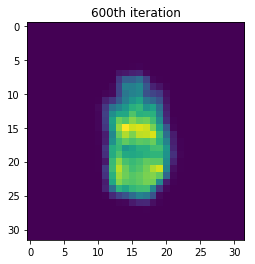

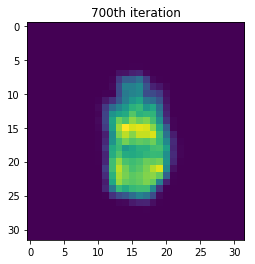

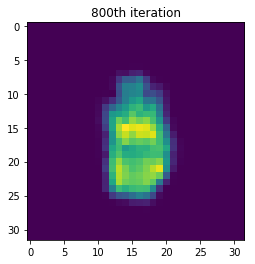

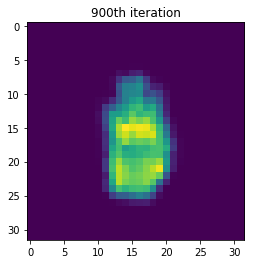

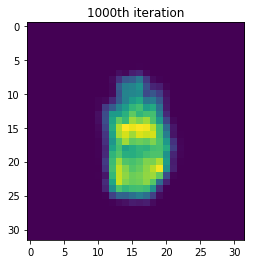

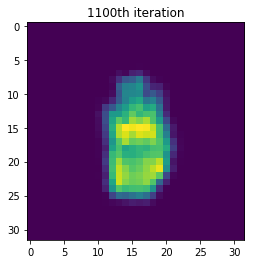

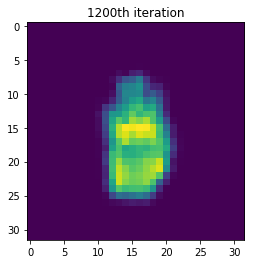

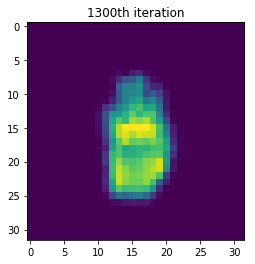

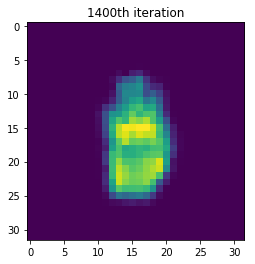

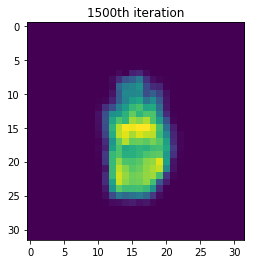

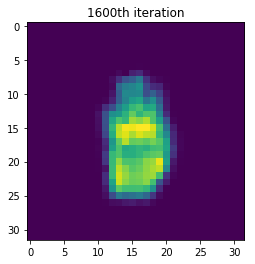

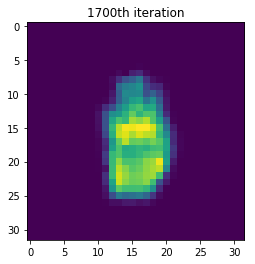

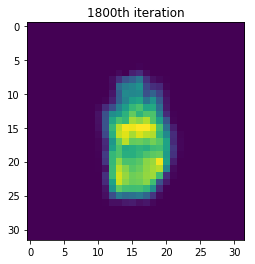

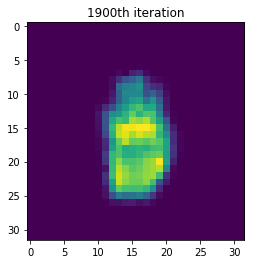

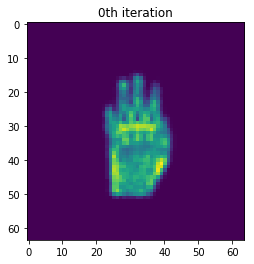

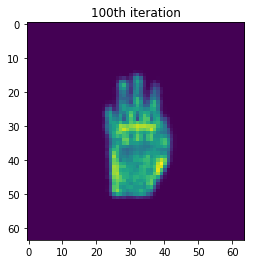

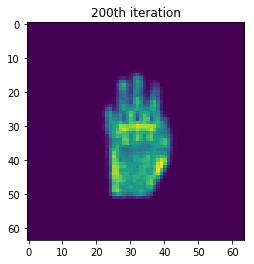

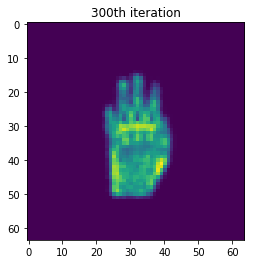

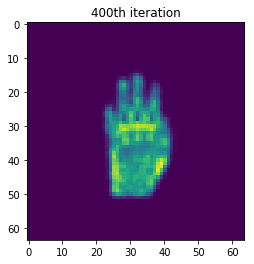

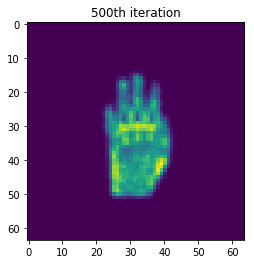

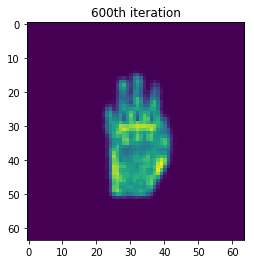

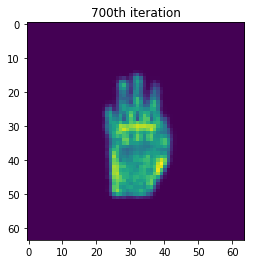

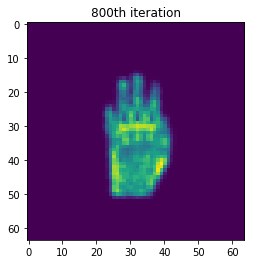

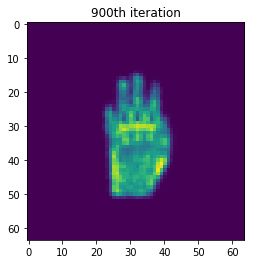

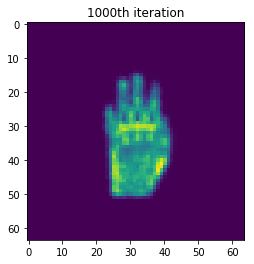

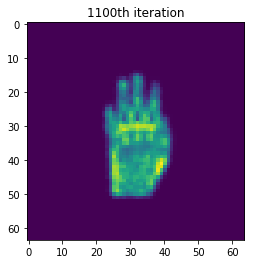

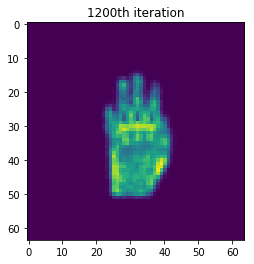

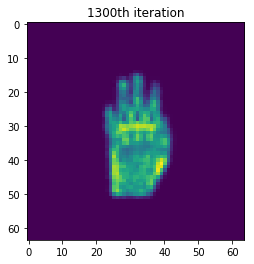

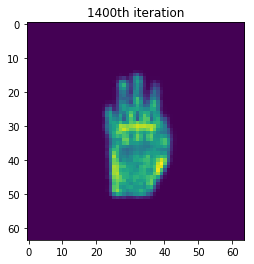

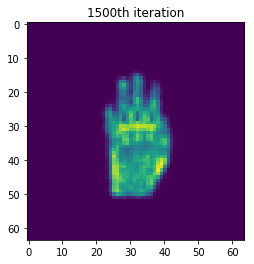

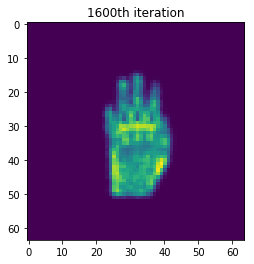

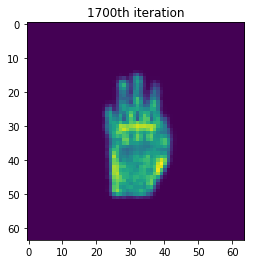

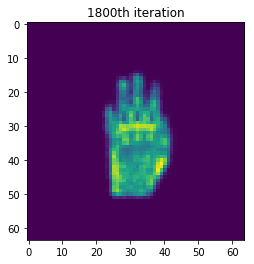

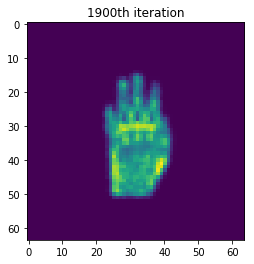

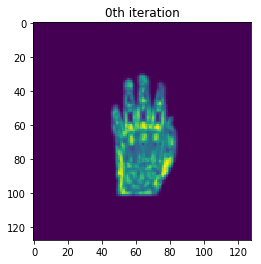

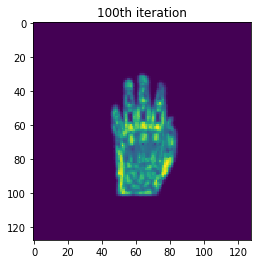

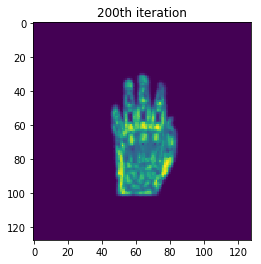

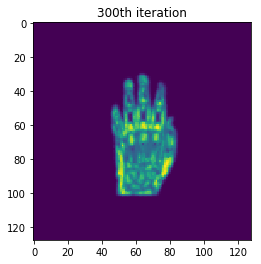

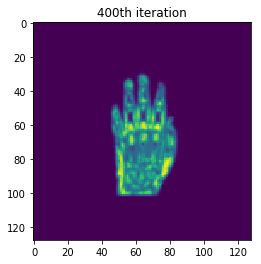

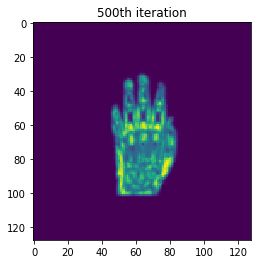

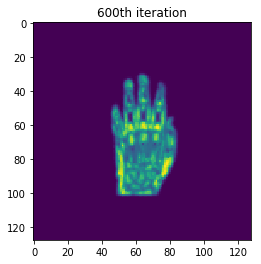

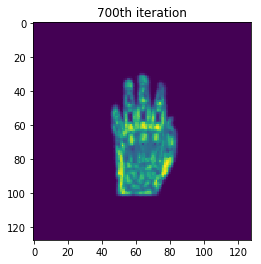

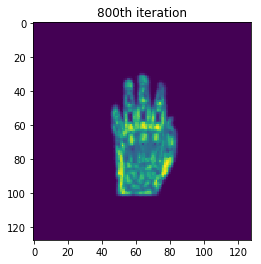

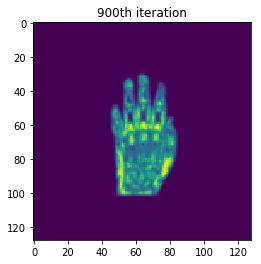

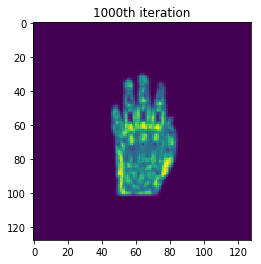

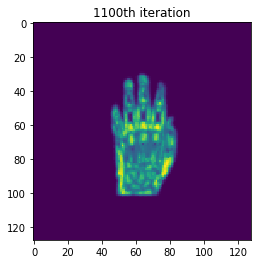

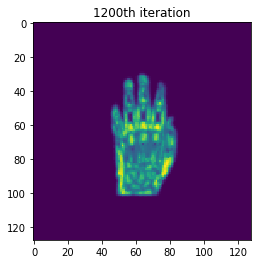

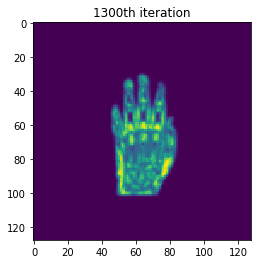

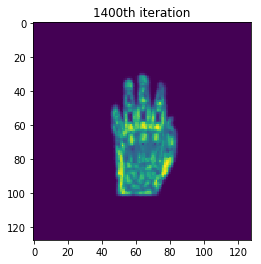

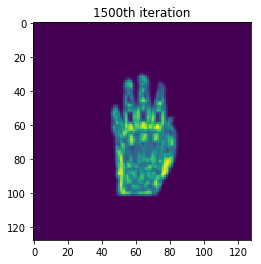

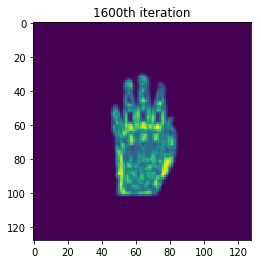

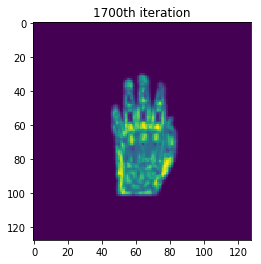

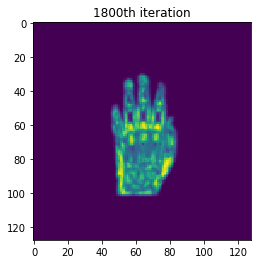

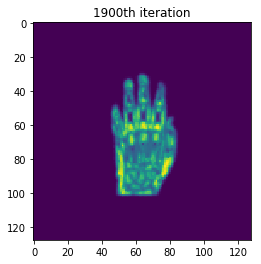

In [20]:
lr = 1e-5
iteration = 2000
n = 0
cost_hist = np.zeros(iteration*5)
best_loss = 0
loss = 0
trans_matrix = getTrans_matrix(0)
best_matrix = getTrans_matrix(0)


for i in range(5):
    if i == 0:
        reference = downsample_img[8]
        template = gen_DS_img[8]
    elif i ==1:
        reference = downsample_img[16]
        template = gen_DS_img[16]
    elif i ==2:
        reference = downsample_img[32]
        template = gen_DS_img[32]
    elif i ==3:
        reference = downsample_img[64]
        template = gen_DS_img[64]
    elif i ==4:
        reference = downsample_img[128]
        template = gen_DS_img[128]
    
    M, N = reference.shape
    
    n = 0
    best_loss = 1e10
    trans_matrix = best_matrix
    
    
    while n < iteration:
        grid_r = getGrid_r(M, N)
        rg_trans = getTrans(trans_matrix, grid_r)
        floor_ceil, y1_y2_rg = getCoordinate(rg_trans)
        gen_image, dT= bilinear(floor_ceil=floor_ceil, y1_y2_rg=y1_y2_rg, template=template, M=M, N=N)
        loss = getCost(reference, gen_image)
        cost_hist[n + i*iteration] = loss
        if best_loss > cost_hist[n + i*iteration]:
            best_loss = cost_hist[n + i*iteration]
            best_matrix = trans_matrix.copy()
            
        gradient = np.array(computeGradient(reference=reference, gen_image=gen_image, dT=dT, grid_r=grid_r))
        gradient = gradient.reshape((3,3)) / (M*N)
        if n%100==0:
            print("\n")
            print("{}th iteration loss: is {}".format((n+i*iteration), cost_hist[n+i*iteration]))
            print(trans_matrix)
            testGradient(M, N, trans_matrix, 1e-4, reference, template)
            plt.figure((n+i*iteration)//100)
            plt.imshow(gen_image)
            plt.title("{}th iteration".format(n))
        trans_matrix = trans_matrix - lr * gradient
        n = n+1

    

In [21]:
print(getTrans_matrix(-np.pi/4))

[[ 0.70710678  0.70710678  0.        ]
 [-0.70710678  0.70710678  0.        ]
 [ 0.          0.          1.        ]]


In [22]:
print(trans_matrix)
print(loss)

print(best_matrix)
print(best_loss)

[[ 0.70750576  0.70838161 -0.01634051]
 [-0.70749332  0.70688762  0.01551573]
 [ 0.          0.          1.        ]]
118437.34128190778
[[ 0.70752178  0.70837597 -0.01634843]
 [-0.70749259  0.70688734  0.01552335]
 [ 0.          0.          1.        ]]
118437.34128190778


Text(0,0.5,'cost')

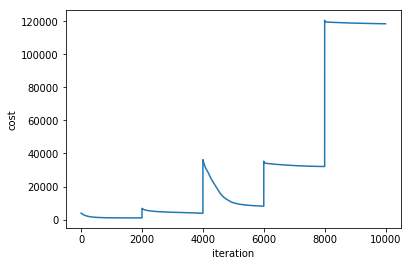

In [23]:
plt.plot(np.arange(iteration*5), cost_hist)
plt.xlabel("iteration")
plt.ylabel("cost")

cost is 118436.91935726398


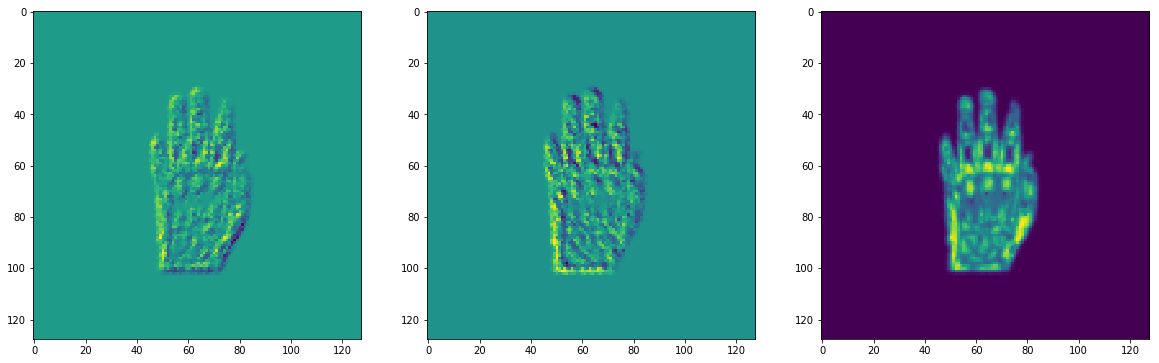

In [24]:
M, N = 128, 128
template = gen_DS_img[128]
reference = downsample_img[128]
grid_r = getGrid_r(M, N)
rg_trans = getTrans(trans_matrix, grid_r)
floor_ceil, y1_y2_rg = getCoordinate(rg_trans)
gen_image, dT = bilinear(floor_ceil=floor_ceil, y1_y2_rg=y1_y2_rg, template=template, M=M, N=N)
cost = getCost(reference, gen_image)
gradient = computeGradient(reference=reference, gen_image=gen_image, dT=dT, grid_r=grid_r)
print("cost is " + str(cost))
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 10))
ax0.imshow(dT[0])
ax1.imshow(dT[1])
ax2.imshow(gen_image)

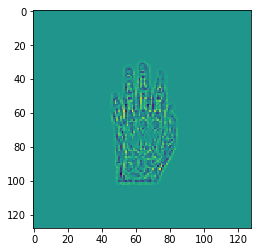

In [25]:
plt.imshow(gen_image - reference)

In [26]:
# lr = 1e-9
# iteration = 8000
# n = 0
# cost_hist = np.zeros(iteration)
# gradient = np.zeros_like(trans_matrix)
# gradient[2][2] = 1
# while n < iteration:
    
#     gen_image, nu_gradient, cost_hist[n] = testGradient(M, N, trans_matrix, 1e-4, reference, template)
#     gradient[0:2, :] = nu_gradient.reshape(2,3)
#     trans_matrix = trans_matrix - lr * gradient
#     if n%100==0:
#         print("\n")
# #         print("{}th iteration loss: is {}".format(n, cost_hist[n]))
#         plt.figure(n//100)
#         plt.imshow(gen_image)
#         plt.title("{}th iteration".format(n))
#     n = n+1
#     if n > 4000:
#         lr = 1e-10
